# Проект "Определение возраста покупателей"

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

В данном проекте нам необходимо провести исследовательский анализ данных:
- Загрузить данные.
- Подготовить данные к обучению и создать datagen_flow.
- Визуализировать 10-15 фотографий из датасета.

И обучить нейросеть на базе ResNet50:
- Создать четыре функции: load_train, load_test, create_model, train_model.
- Использовать метрику качества MAE.
- Достигнуть показатель MAE < 8.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
# загружаем и осматриваем данные

data = pd.read_csv('/datasets/faces/labels.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.shape

(7591, 2)

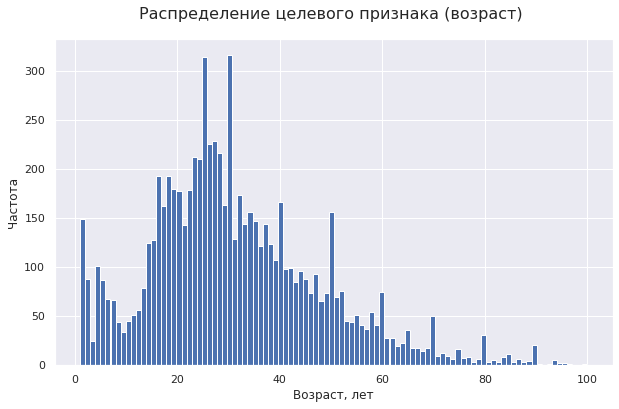

In [4]:
# смотрим на распределение целевого признака (возраста)

sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 6))

data['real_age'].hist(bins=100)

plt.title(
    label="Распределение целевого признака (возраст) ", 
    fontdict={"fontsize":16},
    pad=20
)
plt.xlabel('Возраст, лет')
plt.ylabel('Частота')
plt.show()
None

In [5]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [6]:
# создаем datagen_flow 

datagen = ImageDataGenerator(rescale=1./255) 
datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224), 
    batch_size=32,
    class_mode='raw',
    seed=12345) 

Found 7591 validated image filenames.


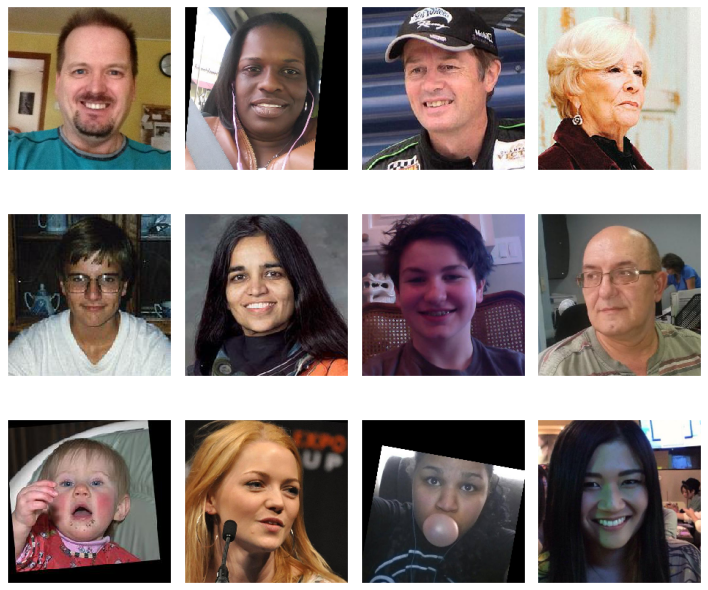

In [7]:
# выведем 12 фотографий для примера

features, target = next(datagen_flow)


fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В течение данного этапа мы провели исследовательский анализ данных и выполнили следующие действия:
- Загрузили и ознакомились с имеющимися данными.
- Подготовили данные к обучению и создали train_datagen_flow.
- Визуализировали 12 фотографий из датасета.

Итак, мы имеем массив данных, состоящих из 7591 фотографий и соответствующей разметкой - возрастом изображенных на них людей. Количество имеющихся данных позволяет нам использовать все возможности ResNet50, не "замораживая" её части, а обучая модель целиком.  
Как мы видим, распределение данных возраста выглядит адекватно. Значительных выбросов или аномалий не наблюдается. Данные распределены от 1 до 100 лет с медианой в 29 лет и стандартным отклонением в 17.14.  
Рассмотрев примеры на фото, мы видим что данные достаточно разнородны - на них присутствуют люди различных возрастов, пола, и расы. Также мы видим, что некоторые фото уже имею некоторые дефекты - сдвиги и повороты.  
В процессе работы попробуем использовать аугментации горизонтального и вертикального отражений, сдвигов и вращений фотографий и сравним результаты работы модели с неизмененными данными.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    
    data = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       #horizontal_flip=True,
                                       #vertical_flip=True,
                                       rescale=1./255) 
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=data,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224), 
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345) 
    
    return train_datagen_flow


def load_test(path):
    
    data = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255) 
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=data,
                                                         directory=path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224), 
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345) 
    
    return test_datagen_flow


def create_model(input_shape):
    

    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                     include_top=False,
                     weights='imagenet') 
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data) 
    if validation_steps is None:
        validation_steps = len(test_data) 

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 68s - loss: 10.8491 - mean_absolute_error: 10.8492 - val_loss: 24.2816 - val_mean_absolute_error: 24.2914
Epoch 2/10
178/178 - 38s - loss: 6.6951 - mean_absolute_error: 6.6955 - val_loss: 19.4530 - val_mean_absolute_error: 19.4207
Epoch 3/10
178/178 - 38s - loss: 5.5224 - mean_absolute_error: 5.5227 - val_loss: 16.4802 - val_mean_absolute_error: 16.4549
Epoch 4/10
178/178 - 38s - loss: 4.7756 - mean_absolute_error: 4.7759 - val_loss: 8.2138 - val_mean_absolute_error: 8.2206
Epoch 5/10
178/178 - 38s - loss: 4.3094 - mean_absolute_error: 4.3096 - val_loss: 7.8677 - val_mean_absolute_error: 7.8853
Epoch 6/10
178/178 - 38s - loss: 3.8195 - mean_absolute_error: 3.8195 - val_loss: 6.4482 - val_mean_absolute_error: 6.4495
Epoch 7/10
178/178 - 38s - loss: 3.5929 - mean_absolute_error: 3.5932 - val_loss: 6.2269 - val_mean_absolute_error: 6.2404
Epoch 8/10
178/178 - 38s - loss: 3.1211 - mean_absolute_error: 3.1209 - val_loss: 5.9125 - val_mean_absolute_error: 5.9322
Epoch 9/10
178/178 - 38s - loss: 3.0231 - mean_absolute_error: 3.0232 - val_loss: 7.0162 - val_mean_absolute_error: 7.0221
Epoch 10/10
178/178 - 38s - loss: 2.8042 - mean_absolute_error: 2.8042 - val_loss: 6.6945 - val_mean_absolute_error: 6.6961

60/60 - 9s - loss: 6.6945 - mean_absolute_error: 6.6961
Test MAE: 6.6961



```

## Анализ обученной модели

В течение данного проекта мы обучили модель на базе ResNet50. Ключевые особенности:
- Отмастабировали исходные данные яркости пикселей до [0, 1].
- Подготовили данные с помощью flow_from_dataframe.
- Привели все данные к размеру 224х224 пикселей.
- Выбрали размер одного батча =32.
- Разделили датасет на обучающую и валидационную выборки в соотношении 3:1, использовав одинаковый seed.

- Использовали модель ResNet50.
- Мы использовали предобученные данные весов 'imagenet'. 
- Заменили последний блок модели с 1000 нейронов на 1, необходимый для нашей задачи регрессии, а также заменили тип активации с классификации (sparse_categorical_crossentropy) на ReLU, подходящий для данной задачи.
- В процессе работы были также протестированы следующие параметры ImageDataGenerator, но были удалены из модели, так как при их использовании показатель итоговой метрики был хуже:
    - horizontal_flip
    - vertical_flip
    - width_shift_range
    - height_shift_range
    - rotation_range
- Использовали оптимизатор Adam.
- Использовали функцию потерь и метрику MAE.

Итого: цель проекта достигнута. Была построена модель, имеющая метрику MAE=6.6961.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы